In [1]:
from keras.applications import ResNet50

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

conv_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

Using TensorFlow backend.
/data/peng/anaconda/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [2]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [3]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(133,activation='softmax'))

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 49,870,853
Trainable params: 49,817,733
Non-trainable params: 53,120
_________________________________________________________________


In [5]:
conv_base.trainable = False

In [6]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './dogImages'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.


In [8]:
from keras.callbacks import ModelCheckpoint 
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

checkpointer = ModelCheckpoint(filepath='dogsImages.pretrained.augmentation.model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)
history = model.fit_generator(
      train_generator,
      steps_per_epoch=334,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=42, 
      callbacks=[checkpointer], 
      verbose=2)


Epoch 1/100
 - 527s - loss: 4.7529 - acc: 0.0702 - val_loss: 5.0553 - val_acc: 0.0096

Epoch 00001: val_loss improved from inf to 5.05527, saving model to dogsImages.pretrained.augmentation.model.weights.best.hdf5
Epoch 2/100
 - 277s - loss: 3.6231 - acc: 0.2024 - val_loss: 5.1130 - val_acc: 0.0084

Epoch 00002: val_loss did not improve from 5.05527
Epoch 3/100
 - 279s - loss: 2.9808 - acc: 0.3046 - val_loss: 5.1398 - val_acc: 0.0096

Epoch 00003: val_loss did not improve from 5.05527
Epoch 4/100
 - 274s - loss: 2.5761 - acc: 0.3735 - val_loss: 5.1903 - val_acc: 0.0084

Epoch 00004: val_loss did not improve from 5.05527
Epoch 5/100
 - 258s - loss: 2.3019 - acc: 0.4302 - val_loss: 5.2428 - val_acc: 0.0084

Epoch 00005: val_loss did not improve from 5.05527
Epoch 6/100
 - 265s - loss: 2.0666 - acc: 0.4701 - val_loss: 5.2511 - val_acc: 0.0084

Epoch 00006: val_loss did not improve from 5.05527
Epoch 7/100
 - 264s - loss: 1.9007 - acc: 0.5139 - val_loss: 5.2929 - val_acc: 0.0096

Epoch 000

KeyboardInterrupt: 

In [14]:
model.load_weights('dogsImages.pretrained.augmentation.model.weights.best.hdf5')

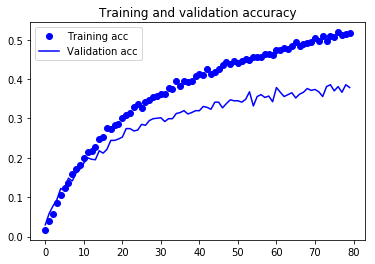

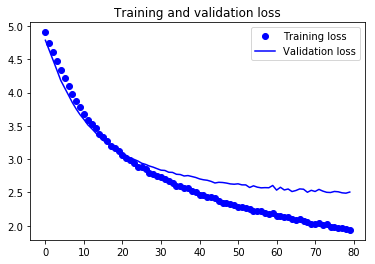

In [15]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [18]:
from keras.callbacks import ModelCheckpoint 
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

checkpointer = ModelCheckpoint(filepath='dogsImages.pretrained.finetuning.augmentation.model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)
history = model.fit_generator(
      train_generator,
      steps_per_epoch=334,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=42, 
      callbacks=[checkpointer], 
      verbose=2)

Epoch 1/15
 - 158s - loss: 1.8364 - acc: 0.5157 - val_loss: 2.4925 - val_acc: 0.3952

Epoch 00001: val_loss improved from inf to 2.49246, saving model to dogsImages.pretrained.finetuning.augmentation.model.weights.best.hdf5
Epoch 2/15
 - 152s - loss: 1.6439 - acc: 0.5533 - val_loss: 2.4254 - val_acc: 0.4192

Epoch 00002: val_loss improved from 2.49246 to 2.42538, saving model to dogsImages.pretrained.finetuning.augmentation.model.weights.best.hdf5
Epoch 3/15
 - 155s - loss: 1.5199 - acc: 0.5856 - val_loss: 2.4940 - val_acc: 0.4180

Epoch 00003: val_loss did not improve from 2.42538
Epoch 4/15
 - 150s - loss: 1.4011 - acc: 0.6210 - val_loss: 2.3379 - val_acc: 0.4275

Epoch 00004: val_loss improved from 2.42538 to 2.33791, saving model to dogsImages.pretrained.finetuning.augmentation.model.weights.best.hdf5
Epoch 5/15
 - 153s - loss: 1.3308 - acc: 0.6287 - val_loss: 2.4536 - val_acc: 0.4347

Epoch 00005: val_loss did not improve from 2.33791
Epoch 6/15
 - 152s - loss: 1.2419 - acc: 0.648

In [19]:
model.load_weights('dogsImages.pretrained.finetuning.augmentation.model.weights.best.hdf5')

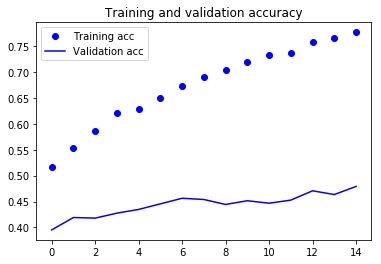

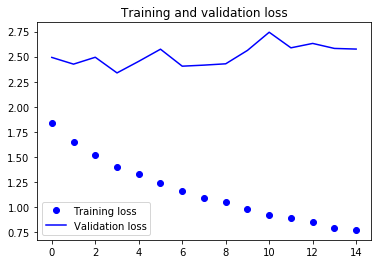

In [20]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

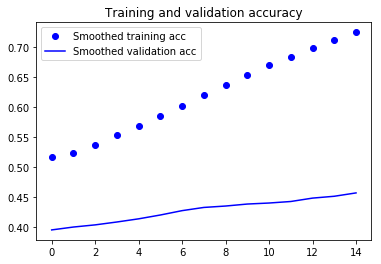

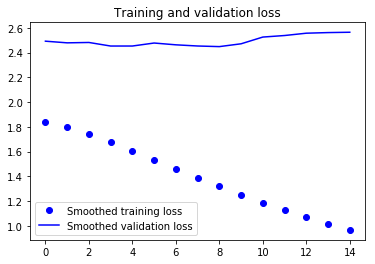

In [21]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor+point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [27]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150,150),
        batch_size=20,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print("test_acc:",test_acc)

Found 836 images belonging to 133 classes.
test_acc: 0.42369478222835494
